In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from    torch import nn, optim
np.set_printoptions(threshold=np.inf)#不使用科学计数法

In [3]:
df = pd.read_csv('./airline_passengers.csv',index_col=0)

In [4]:
dates = pd.date_range('1949-01-01','1960-12-01',freq='MS')

In [5]:
df['Date'] = dates
df.set_index('Date', inplace=True)

In [6]:
df

,Thousands of Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [8]:
data=df.iloc[:,0:1].values

In [9]:
def sliding_windows(data,seq_length):
    x=[]
    y=[]
    
    for i in range(len(data)-seq_length-1):
        _x=data[i:i+seq_length]
        _y=data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [10]:
norm=MinMaxScaler()
training_data=norm.fit_transform(data)

In [11]:
seq_length=4
x,y=sliding_windows(training_data,seq_length)

In [12]:
train_size=int(len(y)*0.8)
test_size=len(y)-train_size

In [13]:
data_new1=Variable(torch.Tensor(x))
data_new2=Variable(torch.Tensor(y))

train1=Variable(torch.Tensor(x[:train_size]))
train2=Variable(torch.Tensor(y[:train_size]))

test1=Variable(torch.Tensor(x[train_size:]))
test2=Variable(torch.Tensor(y[train_size:]))

In [14]:
train1.shape

torch.Size([111, 4, 1])

In [20]:
class LSTM(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(LSTM,self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    
    def forward(self,x):
        h_0=Variable(torch.zeros(1,x.size(0),hidden_size))
        c_0=Variable(torch.zeros(1,x.size(0),hidden_size))
        
        output,(hn,cn)=self.lstm(x,(h_0,c_0))
        hn=hn.view(-1,hidden_size)
        out=self.fc(hn)
        
        return out

In [21]:
num_classes=1
input_size=1
hidden_size=8
num_layers=1

In [22]:
model=LSTM(num_classes,input_size,hidden_size,num_layers)
criteon = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
for i in range(1000):
    model.train()
    output=model(train1)
    optimizer.zero_grad()
    
    loss = criteon(output, train2)
    loss.backward()
    optimizer.step()
    if i%100==0:
        print(i, 'loss:', loss.item())

0 loss: 0.2741676867008209
100 loss: 0.0053544677793979645
200 loss: 0.004094713367521763
300 loss: 0.003021764801815152
400 loss: 0.0026343970093876123
500 loss: 0.002297551603987813
600 loss: 0.002181166782975197
700 loss: 0.002143577206879854
800 loss: 0.002119495067745447
900 loss: 0.0020967917516827583


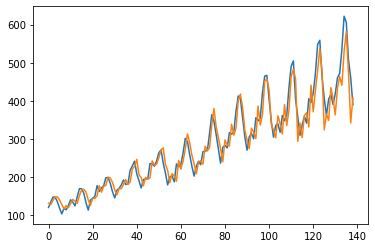

In [24]:
model.eval()
tarin_predict=model(data_new1)

data_predict=tarin_predict.detach().numpy()
data_plot=data_new2.detach().numpy()

data_predict=norm.inverse_transform(data_predict)
data_plot=norm.inverse_transform(data_plot)

plt.plot(data_plot)
plt.plot(data_predict)
plt.show()